## Importing Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
import mplfinance as mpf

## Importing Data

In [94]:
def get_data(ticker, interval='1d', period='10y'):
    data = yf.download(ticker, interval=interval, period=period, rounding=True, multi_level_index=False)
    data.drop(columns=['Adj Close'], inplace=True)
    data = data[['Volume', 'Open', 'High', 'Low', 'Close']]
    return data


df = get_data('AAPL', interval='15m', period='1mo')

[*********************100%***********************]  1 of 1 completed


In [95]:
df.head()

,Volume,Open,High,Low,Close
Datetime,,,,,
2024-12-26 09:30:00,4008896,258.98,260.09,258.10,259.34
2024-12-26 09:45:00,1747595,259.34,259.36,258.02,258.79
2024-12-26 10:00:00,1234525,258.76,258.84,257.95,258.24
2024-12-26 10:15:00,1045564,258.26,258.37,257.63,258.36
2024-12-26 10:30:00,842201,258.36,258.79,258.32,258.51


## Generating Technical Indicators

In [96]:
df.ta.rsi(length=14, append=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2024-12-26 09:30:00 to 2025-01-24 15:45:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  494 non-null    int64  
 1   Open    494 non-null    float64
 2   High    494 non-null    float64
 3   Low     494 non-null    float64
 4   Close   494 non-null    float64
 5   RSI_14  480 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.0 KB


## Trading Strategy

## Price Chart

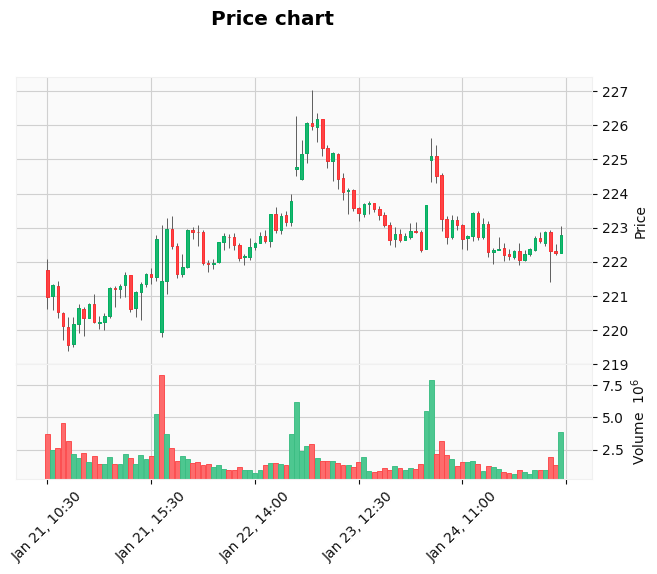

In [97]:
def price_chart(df, type='candle', volume=True, style='yahoo', title='Price chart'):
    df = df.copy()
    #df.columns = df.columns.droplevel(1)
    mpf.plot(df.iloc[-100:,:], type=type, volume=volume, style=style, title=title)


price_chart(df)